In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import classification_report, make_scorer, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import KFold, train_test_split, cross_validate, RepeatedStratifiedKFold, GridSearchCV, cross_val_score
import numpy as np
from imblearn.combine import SMOTETomek, SMOTEENN
from collections import Counter
from imblearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
import seaborn as sns
import sys
sys.path.append('/Users/ayoucruz/Desktop/Data_Science/3nd_Semester/DATA7901 Capstone project/Capstone/Models/Functions')
from Evaluation import *
from Preparation import *
import pickle

In [2]:
X, y, data = preparation_class_threshold()

/Users/ayoucruz/Desktop/Data_Science/3nd_Semester/DATA7901 Capstone project/Capstone/Models/Functions/Preparation.py:717: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df_location = pd.read_csv('../../Dataset/Location.csv')


In [3]:
weather_features = ['Crash_Road_Surface_Condition_Sealed - Dry','Crash_Road_Surface_Condition_Sealed - Wet', 
                    'Crash_Road_Surface_Condition_Unsealed - Dry','Crash_Road_Surface_Condition_Unsealed - Wet', 
                    'Crash_Atmospheric_Condition_Clear', 'Crash_Atmospheric_Condition_Fog','Crash_Atmospheric_Condition_Raining',
                    'Crash_Atmospheric_Condition_Smoke/Dust', 'Crash_Lighting_Condition_Darkness - Lighted',
                    'Crash_Lighting_Condition_Darkness - Not lighted','Crash_Lighting_Condition_Dawn/Dusk','Crash_Lighting_Condition_Daylight',
                    'Crash_Road_Horiz_Align_Curved - view obscured','Crash_Road_Horiz_Align_Curved - view open','Crash_Road_Horiz_Align_Straight', 
                    'Crash_Road_Vert_Align_Crest', 'Crash_Road_Vert_Align_Dip', 'Crash_Road_Vert_Align_Grade','Crash_Road_Vert_Align_Level']

new_features =['Crash_Speed_Limit_100 - 110 km/h', 'Crash_Speed_Limit_60 km/h', 'Crash_Speed_Limit_80 - 90 km/h','Crash_Roadway_Feature_No Roadway Feature',
               'Crash_Speed_Limit_0 - 50 km/h','Crash_Traffic_Control_No traffic control','Crash_Nature_Hit object', 'Crash_Nature_Fall from vehicle',
               'Crash_Controlling_Authority_Locally-controlled', 'Crash_Nature_Rear-end','Crash_Nature_Angle','Crash_Month_Q2','Crash_Nature_Hit pedestrian']
X = X[weather_features + new_features]

### MLP Architecture

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.hidden1 = nn.Linear(32, 256)
        self.hidden2 = nn.Linear(256, 128)
        self.hidden3 = nn.Linear(128, 64)
        self.hidden4 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 4)

    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = F.relu(self.hidden3(x))
        x = F.relu(self.hidden4(x))
        x = self.output(x)
        return x

### Train test split with baseline

In [5]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

X_train_val, X_test, y_train_val, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

### Training function

In [6]:
def train_and_validate(model, train_loader, val_loader, optimizer, criterion, num_epochs):
    training_losses = []
    valid_losses = []
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, labels in tqdm(train_loader):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
        training_loss = train_loss / len(train_loader.dataset)
        training_losses.append(training_loss)
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
        validation_loss = val_loss / len(val_loader.dataset)
        valid_losses.append(validation_loss)
        print(f'Epoch {epoch + 1}, Training Loss: {training_loss}, Validation Loss: {validation_loss}')
    return training_losses, valid_losses

### Evaluation function

In [7]:
def evaluate_model(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.numpy())
            y_true.extend(labels.numpy())

    evaluation_class_8_MLP(y_true, y_pred)

### Training on Baseline

100%|██████████| 7120/7120 [00:03<00:00, 2185.50it/s]


Epoch 1, Training Loss: 0.9349716135314144, Validation Loss: 0.9362097885791261


100%|██████████| 7120/7120 [00:03<00:00, 2237.06it/s]


Epoch 2, Training Loss: 0.9317784910210817, Validation Loss: 0.9350689086624735


100%|██████████| 7120/7120 [00:03<00:00, 2296.47it/s]


Epoch 3, Training Loss: 0.9314978072951258, Validation Loss: 0.9340888850181356


100%|██████████| 7120/7120 [00:03<00:00, 2299.07it/s]


Epoch 4, Training Loss: 0.9310611373216721, Validation Loss: 0.9349933102072372


100%|██████████| 7120/7120 [00:03<00:00, 2263.87it/s]


Epoch 5, Training Loss: 0.9310881691548706, Validation Loss: 0.9337327600555175


100%|██████████| 7120/7120 [00:03<00:00, 2286.92it/s]


Epoch 6, Training Loss: 0.9311301762230051, Validation Loss: 0.9328418776658216


100%|██████████| 7120/7120 [00:03<00:00, 2199.81it/s]


Epoch 7, Training Loss: 0.9307294323520445, Validation Loss: 0.9403870579102112


100%|██████████| 7120/7120 [00:03<00:00, 2314.77it/s]


Epoch 8, Training Loss: 0.9309796709991949, Validation Loss: 0.9318138558947725


100%|██████████| 7120/7120 [00:03<00:00, 2260.94it/s]


Epoch 9, Training Loss: 0.930790091029211, Validation Loss: 0.9329141353915391


100%|██████████| 7120/7120 [00:03<00:00, 2293.17it/s]


Epoch 10, Training Loss: 0.9306569519921172, Validation Loss: 0.9360919575112067


100%|██████████| 7120/7120 [00:03<00:00, 2326.41it/s]


Epoch 11, Training Loss: 0.9309229193482832, Validation Loss: 0.9350813500536865


100%|██████████| 7120/7120 [00:03<00:00, 2222.62it/s]


Epoch 12, Training Loss: 0.9309393874965685, Validation Loss: 0.9381917045124712


100%|██████████| 7120/7120 [00:03<00:00, 2329.60it/s]


Epoch 13, Training Loss: 0.9310314254430474, Validation Loss: 0.9363763006434456


100%|██████████| 7120/7120 [00:03<00:00, 2287.82it/s]


Epoch 14, Training Loss: 0.9307463492427525, Validation Loss: 0.9364903364281477


100%|██████████| 7120/7120 [00:03<00:00, 2325.58it/s]


Epoch 15, Training Loss: 0.9309465991939511, Validation Loss: 0.9339489682788381


100%|██████████| 7120/7120 [00:03<00:00, 2269.23it/s]


Epoch 16, Training Loss: 0.9309300712332955, Validation Loss: 0.9323104418179239


100%|██████████| 7120/7120 [00:03<00:00, 2282.82it/s]


Epoch 17, Training Loss: 0.9307755356063512, Validation Loss: 0.9347863451115741


100%|██████████| 7120/7120 [00:03<00:00, 2312.86it/s]


Epoch 18, Training Loss: 0.9306758543466896, Validation Loss: 0.9428056403280347


100%|██████████| 7120/7120 [00:03<00:00, 2265.50it/s]


Epoch 19, Training Loss: 0.9304699260875715, Validation Loss: 0.934560432174642


100%|██████████| 7120/7120 [00:03<00:00, 2277.31it/s]


Epoch 20, Training Loss: 0.9309522963844798, Validation Loss: 0.9351206702514455


100%|██████████| 7120/7120 [00:03<00:00, 2301.16it/s]


Epoch 21, Training Loss: 0.9308578065687719, Validation Loss: 0.9347447731102353


100%|██████████| 7120/7120 [00:03<00:00, 2241.41it/s]


Epoch 22, Training Loss: 0.9309236834053725, Validation Loss: 0.9331910163650746


100%|██████████| 7120/7120 [00:03<00:00, 2316.37it/s]


Epoch 23, Training Loss: 0.9308085866735842, Validation Loss: 0.9367839246470295


100%|██████████| 7120/7120 [00:03<00:00, 2287.49it/s]


Epoch 24, Training Loss: 0.9309677958498929, Validation Loss: 0.9337656725059504


100%|██████████| 7120/7120 [00:03<00:00, 2313.63it/s]


Epoch 25, Training Loss: 0.9304995579066124, Validation Loss: 0.9368140766797196


100%|██████████| 7120/7120 [00:03<00:00, 2298.56it/s]


Epoch 26, Training Loss: 0.9308185067062962, Validation Loss: 0.9326751218836161


100%|██████████| 7120/7120 [00:03<00:00, 2267.94it/s]


Epoch 27, Training Loss: 0.9304557269923341, Validation Loss: 0.9365554643445833


100%|██████████| 7120/7120 [00:03<00:00, 2237.30it/s]


Epoch 28, Training Loss: 0.930579218911323, Validation Loss: 0.9316832751528576


100%|██████████| 7120/7120 [00:03<00:00, 2222.74it/s]


Epoch 29, Training Loss: 0.9303718153384856, Validation Loss: 0.9407171617000808


100%|██████████| 7120/7120 [00:03<00:00, 2331.47it/s]


Epoch 30, Training Loss: 0.9305205145235074, Validation Loss: 0.9328670448339188
Accuracy:  0.6201016538502054
Precision:  0.49623042915982246
Recall:  0.6201016538502054
F1-Score:  0.4919806811858915
--------------------------------------------
                 precision    recall  f1-score   support

          Fatal       0.00      0.00      0.00      1197
   Minor injury       0.00      0.00      0.00     10365
Property damage       0.48      0.05      0.09     17428
 Serious injury       0.62      0.99      0.76     46954

       accuracy                           0.62     75944
      macro avg       0.28      0.26      0.21     75944
   weighted avg       0.50      0.62      0.49     75944



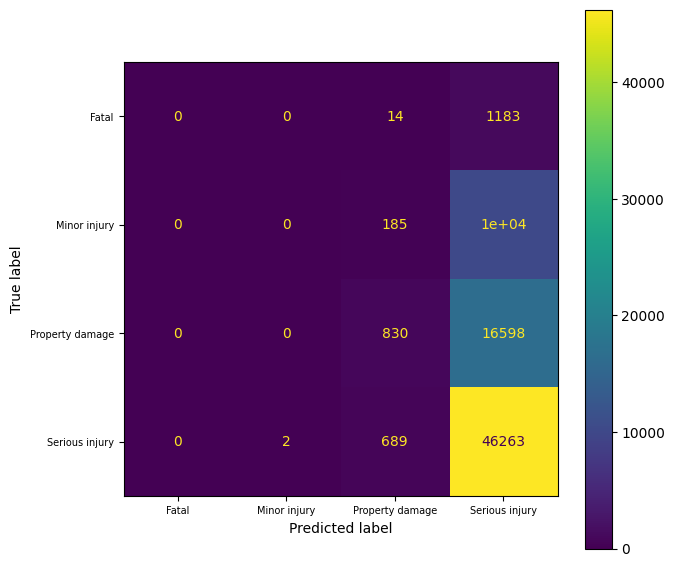

In [90]:
model = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
training_losses, valid_losses = train_and_validate(model, train_loader, val_loader, optimizer, criterion, num_epochs=30)
evaluate_model(model, test_loader)

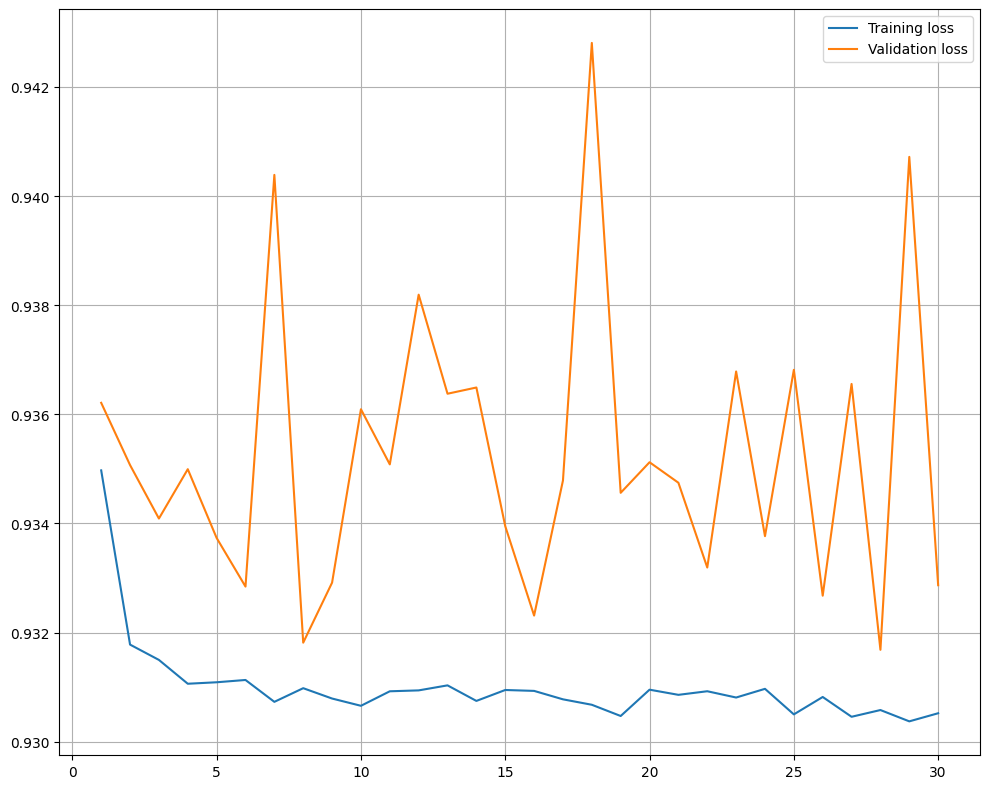

In [91]:
epochs = np.arange(1,31)
plt.figure(figsize=(10, 8))
plt.plot(epochs, training_losses, label="Training loss")
plt.plot(epochs, valid_losses, label="Validation loss")
plt.tight_layout()
plt.legend()
plt.grid()
plt.show()

### SMOTE

In [8]:
X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

X_train_val, X_test, y_train_val, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)
y_smote_tensor = torch.tensor(y_smote, dtype=torch.long)
X_smote_tensor = torch.tensor(X_smote, dtype=torch.float32)

In [9]:
train_data = TensorDataset(X_smote_tensor, y_smote_tensor)
val_data = TensorDataset(X_val, y_val)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

100%|██████████| 17611/17611 [00:16<00:00, 1043.24it/s]


Epoch 1, Training Loss: 1.2609171980653446, Validation Loss: 1.3408049918647613


100%|██████████| 17611/17611 [00:16<00:00, 1049.43it/s]


Epoch 2, Training Loss: 1.2192327703867376, Validation Loss: 1.3297079833330174


100%|██████████| 17611/17611 [00:16<00:00, 1078.95it/s]


Epoch 3, Training Loss: 1.2074057921948735, Validation Loss: 1.3093630147660908


100%|██████████| 17611/17611 [00:16<00:00, 1068.59it/s]


Epoch 4, Training Loss: 1.1987450441561818, Validation Loss: 1.307029383006468


100%|██████████| 17611/17611 [00:16<00:00, 1056.13it/s]


Epoch 5, Training Loss: 1.1918771513539819, Validation Loss: 1.3030141103535147


100%|██████████| 17611/17611 [00:16<00:00, 1076.87it/s]


Epoch 6, Training Loss: 1.185689714169442, Validation Loss: 1.299723116047802


100%|██████████| 17611/17611 [00:18<00:00, 969.37it/s] 


Epoch 7, Training Loss: 1.179592702252093, Validation Loss: 1.2959086845135346


100%|██████████| 17611/17611 [00:16<00:00, 1055.48it/s]


Epoch 8, Training Loss: 1.1732474634585837, Validation Loss: 1.2773981425504244


100%|██████████| 17611/17611 [00:16<00:00, 1068.78it/s]


Epoch 9, Training Loss: 1.166627628396897, Validation Loss: 1.269485535755256


100%|██████████| 17611/17611 [00:16<00:00, 1059.43it/s]


Epoch 10, Training Loss: 1.1595319504057007, Validation Loss: 1.2828379412113295


100%|██████████| 17611/17611 [00:16<00:00, 1063.15it/s]


Epoch 11, Training Loss: 1.1526764022583402, Validation Loss: 1.2778867638225389


100%|██████████| 17611/17611 [00:16<00:00, 1054.46it/s]


Epoch 12, Training Loss: 1.145858066122819, Validation Loss: 1.2706450868001995


100%|██████████| 17611/17611 [00:16<00:00, 1056.29it/s]


Epoch 13, Training Loss: 1.1392482918296638, Validation Loss: 1.2792538569346


100%|██████████| 17611/17611 [00:16<00:00, 1065.51it/s]


Epoch 14, Training Loss: 1.1329099722755533, Validation Loss: 1.2613052790903083


100%|██████████| 17611/17611 [00:16<00:00, 1073.29it/s]


Epoch 15, Training Loss: 1.127056075385961, Validation Loss: 1.2526343790281564


100%|██████████| 17611/17611 [00:16<00:00, 1057.75it/s]


Epoch 16, Training Loss: 1.121498056453956, Validation Loss: 1.2672436608663415


100%|██████████| 17611/17611 [00:16<00:00, 1072.02it/s]


Epoch 17, Training Loss: 1.116385452203303, Validation Loss: 1.269025095456219


100%|██████████| 17611/17611 [00:16<00:00, 1090.27it/s]


Epoch 18, Training Loss: 1.1114768545149891, Validation Loss: 1.2918580741986803


100%|██████████| 17611/17611 [00:16<00:00, 1097.79it/s]


Epoch 19, Training Loss: 1.1069066636468459, Validation Loss: 1.2731931400439718


100%|██████████| 17611/17611 [00:16<00:00, 1094.29it/s]


Epoch 20, Training Loss: 1.1026350408635957, Validation Loss: 1.2814391705631443


100%|██████████| 17611/17611 [00:16<00:00, 1085.82it/s]


Epoch 21, Training Loss: 1.0986814760396206, Validation Loss: 1.2632510687194056


100%|██████████| 17611/17611 [00:16<00:00, 1077.22it/s]


Epoch 22, Training Loss: 1.0950000265168494, Validation Loss: 1.259121533265471


100%|██████████| 17611/17611 [00:15<00:00, 1103.44it/s]


Epoch 23, Training Loss: 1.0915459919069246, Validation Loss: 1.2068549073886459


100%|██████████| 17611/17611 [00:16<00:00, 1091.90it/s]


Epoch 24, Training Loss: 1.08836911855336, Validation Loss: 1.2572012532062504


100%|██████████| 17611/17611 [00:16<00:00, 1086.73it/s]


Epoch 25, Training Loss: 1.085535924193881, Validation Loss: 1.2419525020732576


100%|██████████| 17611/17611 [00:16<00:00, 1091.36it/s]


Epoch 26, Training Loss: 1.0829610796221942, Validation Loss: 1.254952295002565


100%|██████████| 17611/17611 [00:16<00:00, 1068.39it/s]


Epoch 27, Training Loss: 1.080468340811685, Validation Loss: 1.230642573029528


100%|██████████| 17611/17611 [00:16<00:00, 1078.81it/s]


Epoch 28, Training Loss: 1.078122712302623, Validation Loss: 1.2573504601014147


100%|██████████| 17611/17611 [00:16<00:00, 1082.17it/s]


Epoch 29, Training Loss: 1.076225858994973, Validation Loss: 1.2474295808934166


100%|██████████| 17611/17611 [00:16<00:00, 1087.41it/s]


Epoch 30, Training Loss: 1.0741610443032596, Validation Loss: 1.248903342711339
Accuracy:  0.29958917096808174
Precision:  0.5344829092023003
Recall:  0.29958917096808174
F1-Score:  0.32614057237711097
--------------------------------------------
                 precision    recall  f1-score   support

          Fatal       0.05      0.45      0.08      1197
   Minor injury       0.18      0.51      0.27     10365
Property damage       0.34      0.37      0.35     17428
 Serious injury       0.70      0.22      0.34     46954

       accuracy                           0.30     75944
      macro avg       0.31      0.39      0.26     75944
   weighted avg       0.53      0.30      0.33     75944



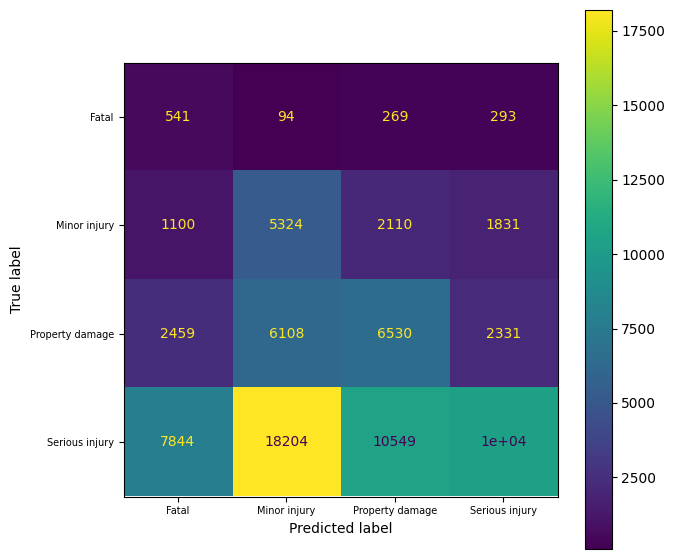

In [10]:
model = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)
training_losses, valid_losses = train_and_validate(model, train_loader, val_loader, optimizer, criterion, num_epochs=30)

evaluate_model(model, test_loader)

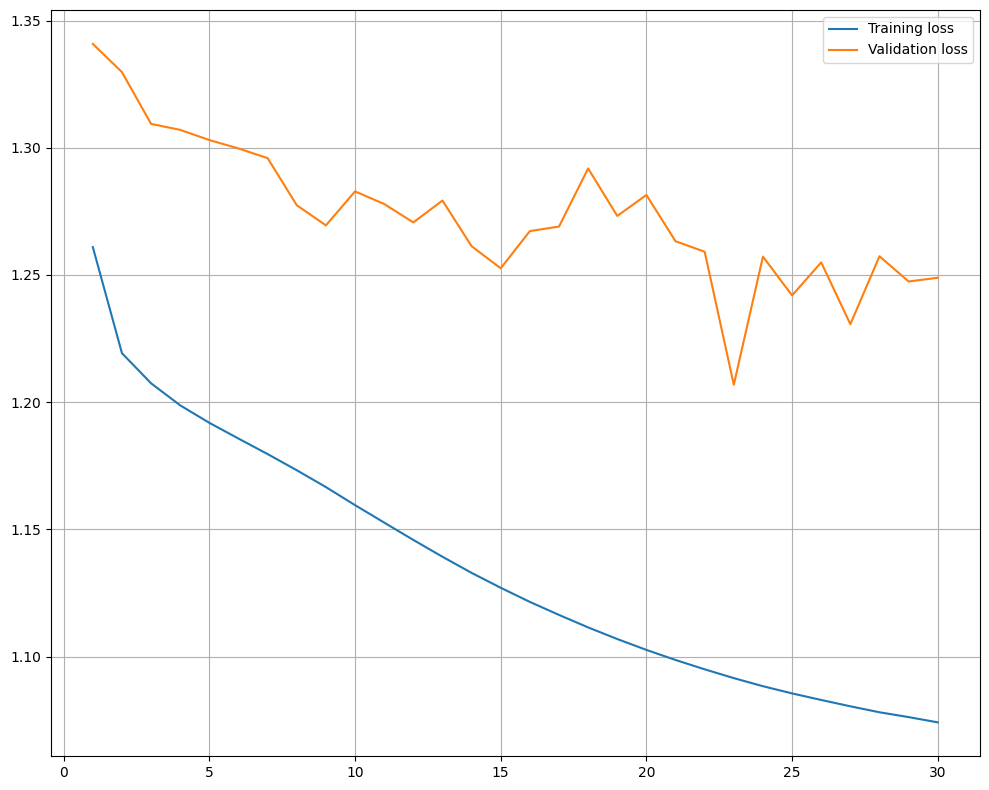

In [11]:
epochs = np.arange(1,31)
plt.figure(figsize=(10, 8))
plt.plot(epochs, training_losses, label="Training loss")
plt.plot(epochs, valid_losses, label="Validation loss")
plt.tight_layout()
plt.legend()
plt.grid()
plt.show()

### Undersampling CNN

In [12]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

under = RandomUnderSampler(random_state=42)
X_under, y_under = under.fit_resample(X_train, y_train)

X_train = torch.tensor(X_under.values.reshape(-1, 1, 13, 4), dtype=torch.float32)
y_train = torch.tensor(y_under, dtype=torch.long)
X_val = torch.tensor(X_val.values.reshape(-1, 1, 13, 4), dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)
X_test = torch.tensor(X_test.values.reshape(-1, 1, 13, 4), dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)
test_data = TensorDataset(X_test, y_test)

100%|██████████| 6838/6838 [00:12<00:00, 539.22it/s]


Epoch 1, Training Loss: 0.9193894119192199, Validation Loss: 0.9192206150893245
Accuracy:  0.6211628895378329
Precision:  0.4990813972573407
Recall:  0.6211628895378329
F1-Score:  0.49529387977109324
--------------------------------------------
                 precision    recall  f1-score   support

          Fatal       0.00      0.00      0.00      1132
   Minor injury       0.00      0.00      0.00      9993
Property damage       0.49      0.05      0.10     16654
 Serious injury       0.62      0.98      0.76     45160

       accuracy                           0.62     72939
      macro avg       0.28      0.26      0.22     72939
   weighted avg       0.50      0.62      0.50     72939



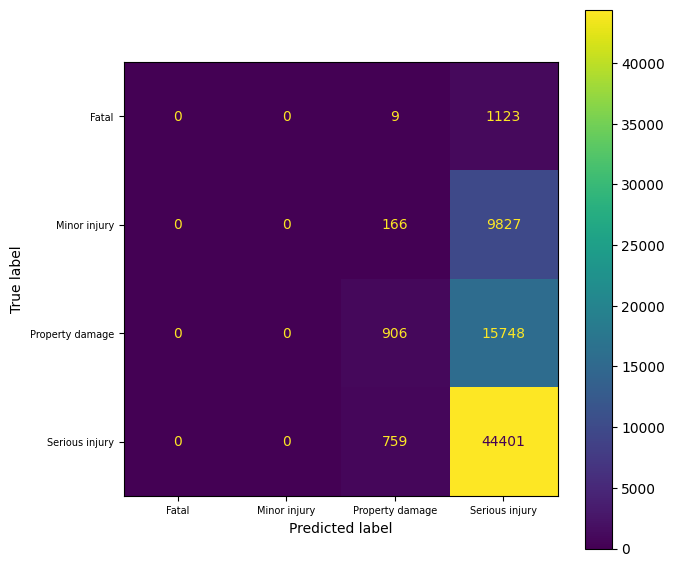

In [13]:
train_and_validate(model, train_loader, val_loader, optimizer, criterion, num_epochs=1)

evaluate_model(model, test_loader)

### SMOTEENN CNN

In [14]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

smoteenn = SMOTEENN(random_state=42)
X_smoteen, y_smoteenn = smoteenn.fit_resample(X_train, y_train)

X_train = torch.tensor(X_smoteen.values.reshape(-1, 1, 13, 4), dtype=torch.float32)
y_train = torch.tensor(y_smoteenn, dtype=torch.long)
X_val = torch.tensor(X_val.values.reshape(-1, 1, 13, 4), dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)
X_test = torch.tensor(X_test.values.reshape(-1, 1, 13, 4), dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)
test_data = TensorDataset(X_test, y_test)

In [66]:
smoteenn = SMOTEENN(random_state=42)
X_smoteenn, y_smoteenn = smoteenn.fit_resample(X_train, y_train)
y_smoteenn_tensor = torch.tensor(y_smoteenn, dtype=torch.long)
X_smoteenn_tensor = torch.tensor(X_smoteenn, dtype=torch.float32)

train_data = TensorDataset(X_smoteenn_tensor, y_smoteenn_tensor)
val_data = TensorDataset(X_val, y_val)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

100%|██████████| 3730/3730 [00:02<00:00, 1761.54it/s]


Epoch 1, Training Loss: 0.943206135979711, Validation Loss: 1.7126557975677825


100%|██████████| 3730/3730 [00:01<00:00, 1969.46it/s]


Epoch 2, Training Loss: 0.824266910358197, Validation Loss: 1.7487366408389071


100%|██████████| 3730/3730 [00:01<00:00, 1961.49it/s]


Epoch 3, Training Loss: 0.8089889396441917, Validation Loss: 1.753164523879507


100%|██████████| 3730/3730 [00:01<00:00, 1905.16it/s]


Epoch 4, Training Loss: 0.7969663775238989, Validation Loss: 1.8182286257539397


100%|██████████| 3730/3730 [00:01<00:00, 1957.15it/s]


Epoch 5, Training Loss: 0.7859248636087394, Validation Loss: 1.7977254636971074


100%|██████████| 3730/3730 [00:01<00:00, 1977.54it/s]


Epoch 6, Training Loss: 0.7764951358084778, Validation Loss: 1.8440992323601069


100%|██████████| 3730/3730 [00:01<00:00, 1886.93it/s]


Epoch 7, Training Loss: 0.7686726126309203, Validation Loss: 1.8500390777620037


100%|██████████| 3730/3730 [00:01<00:00, 1961.81it/s]


Epoch 8, Training Loss: 0.7617201148760941, Validation Loss: 1.8799872932702313


100%|██████████| 3730/3730 [00:01<00:00, 1945.48it/s]


Epoch 9, Training Loss: 0.7555201963488835, Validation Loss: 1.8780455282763435


100%|██████████| 3730/3730 [00:01<00:00, 1948.54it/s]


Epoch 10, Training Loss: 0.7496570340920894, Validation Loss: 1.879108808257363


100%|██████████| 3730/3730 [00:01<00:00, 1927.87it/s]


Epoch 11, Training Loss: 0.744472054190257, Validation Loss: 1.9161940122773344


100%|██████████| 3730/3730 [00:01<00:00, 1962.71it/s]


Epoch 12, Training Loss: 0.739862474135076, Validation Loss: 1.9176619896255327


100%|██████████| 3730/3730 [00:02<00:00, 1764.96it/s]


Epoch 13, Training Loss: 0.7351994945364516, Validation Loss: 1.9348073960430539


100%|██████████| 3730/3730 [00:02<00:00, 1679.88it/s]


Epoch 14, Training Loss: 0.7302225513768424, Validation Loss: 1.944587594664387


100%|██████████| 3730/3730 [00:02<00:00, 1500.94it/s]


Epoch 15, Training Loss: 0.7253643408546682, Validation Loss: 1.9761545951205939


100%|██████████| 3730/3730 [00:02<00:00, 1792.33it/s]


Epoch 16, Training Loss: 0.7206723451695289, Validation Loss: 1.9818169667046954


100%|██████████| 3730/3730 [00:01<00:00, 1951.06it/s]


Epoch 17, Training Loss: 0.716230045096169, Validation Loss: 1.9703926093131539


100%|██████████| 3730/3730 [00:01<00:00, 1977.02it/s]


Epoch 18, Training Loss: 0.7120326033073502, Validation Loss: 1.9610343599525402


100%|██████████| 3730/3730 [00:02<00:00, 1801.61it/s]


Epoch 19, Training Loss: 0.7079267576914338, Validation Loss: 1.9923263567335097


100%|██████████| 3730/3730 [00:02<00:00, 1824.81it/s]


Epoch 20, Training Loss: 0.7039237250314263, Validation Loss: 2.0128493469507114


100%|██████████| 3730/3730 [00:02<00:00, 1695.11it/s]


Epoch 21, Training Loss: 0.7001428212655068, Validation Loss: 2.032768506565775


100%|██████████| 3730/3730 [00:02<00:00, 1469.16it/s]


Epoch 22, Training Loss: 0.6965308051636603, Validation Loss: 2.0207142929727935


100%|██████████| 3730/3730 [00:01<00:00, 1884.55it/s]


Epoch 23, Training Loss: 0.6929991969287684, Validation Loss: 2.075711957473819


100%|██████████| 3730/3730 [00:02<00:00, 1846.39it/s]


Epoch 24, Training Loss: 0.6893898855267102, Validation Loss: 2.0327277302578755


100%|██████████| 3730/3730 [00:01<00:00, 1872.24it/s]


Epoch 25, Training Loss: 0.68564602114277, Validation Loss: 2.040755451585751


100%|██████████| 3730/3730 [00:01<00:00, 1899.65it/s]


Epoch 26, Training Loss: 0.6819982618760493, Validation Loss: 2.054448345897196


100%|██████████| 3730/3730 [00:01<00:00, 1920.79it/s]


Epoch 27, Training Loss: 0.6785158640485724, Validation Loss: 2.0625477980150886


100%|██████████| 3730/3730 [00:02<00:00, 1793.82it/s]


Epoch 28, Training Loss: 0.6752904688949488, Validation Loss: 1.9969910134709599


100%|██████████| 3730/3730 [00:01<00:00, 1971.72it/s]


Epoch 29, Training Loss: 0.6721081252013897, Validation Loss: 2.0631182535071653


100%|██████████| 3730/3730 [00:01<00:00, 1961.60it/s]


Epoch 30, Training Loss: 0.6690387480395369, Validation Loss: 2.083000933874097
Accuracy:  0.33689297377014643
Precision:  0.49603928241853873
Recall:  0.33689297377014643
F1-Score:  0.37168567017832055
--------------------------------------------
                 precision    recall  f1-score   support

          Fatal       0.03      0.77      0.05      1197
   Minor injury       0.18      0.04      0.06     10365
Property damage       0.37      0.05      0.08     17428
 Serious injury       0.62      0.50      0.56     46954

       accuracy                           0.34     75944
      macro avg       0.30      0.34      0.19     75944
   weighted avg       0.50      0.34      0.37     75944



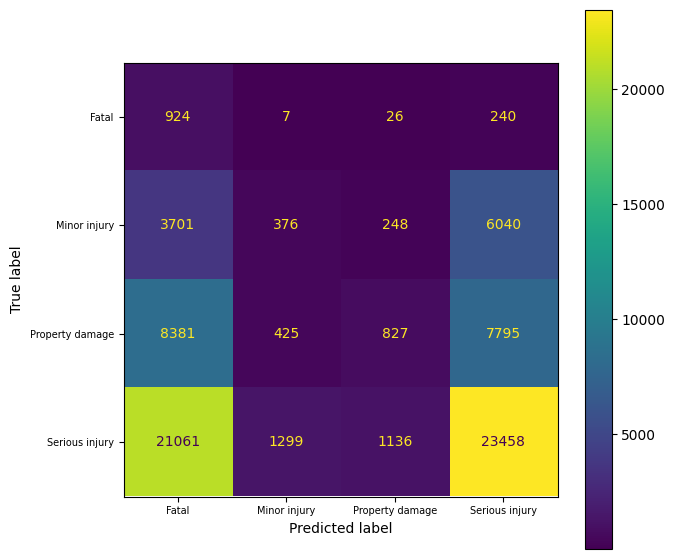

In [70]:
model = MLP()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
training_losses, valid_losses = train_and_validate(model, train_loader, val_loader, optimizer, criterion, num_epochs=30)

evaluate_model(model, test_loader)

In [ ]:
epochs = np.arange(1,31)
plt.figure(figsize=(10, 8))
plt.plot(epochs, training_losses, label="Training loss")
plt.plot(epochs, valid_losses, label="Validation loss")
plt.tight_layout()
plt.legend()
plt.grid()
plt.show()

### TOMEK CNN

In [16]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

tomek = SMOTETomek(random_state=42)
X_tomek, y_tomek = tomek.fit_resample(X_train, y_train)

X_train = torch.tensor(X_tomek.values.reshape(-1, 1, 13, 4), dtype=torch.float32)
y_train = torch.tensor(y_tomek, dtype=torch.long)
X_val = torch.tensor(X_val.values.reshape(-1, 1, 13, 4), dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)
X_test = torch.tensor(X_test.values.reshape(-1, 1, 13, 4), dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)
test_data = TensorDataset(X_test, y_test)

100%|██████████| 6838/6838 [00:12<00:00, 555.15it/s]


Epoch 1, Training Loss: 0.9229028118671933, Validation Loss: 0.9220648098108637


100%|██████████| 6838/6838 [00:11<00:00, 580.07it/s]


Epoch 2, Training Loss: 0.9207450741962985, Validation Loss: 0.9195506833699538


100%|██████████| 6838/6838 [00:11<00:00, 577.62it/s]


Epoch 3, Training Loss: 0.9197782188507533, Validation Loss: 0.9206102593562008


100%|██████████| 6838/6838 [00:11<00:00, 582.60it/s]


Epoch 4, Training Loss: 0.9190394062426382, Validation Loss: 0.9199567036244711


100%|██████████| 6838/6838 [00:11<00:00, 579.00it/s]


Epoch 5, Training Loss: 0.9181922288464309, Validation Loss: 0.9186494029124443


100%|██████████| 6838/6838 [00:11<00:00, 578.25it/s]


Epoch 6, Training Loss: 0.9175825653435082, Validation Loss: 0.9217155484930336


100%|██████████| 6838/6838 [00:11<00:00, 580.00it/s]


Epoch 7, Training Loss: 0.9170959385766916, Validation Loss: 0.9187924925247956


100%|██████████| 6838/6838 [00:11<00:00, 578.58it/s]


Epoch 8, Training Loss: 0.9165528583447071, Validation Loss: 0.9184475025324083


100%|██████████| 6838/6838 [00:11<00:00, 574.06it/s]


Epoch 9, Training Loss: 0.9160015277906896, Validation Loss: 0.9197492245017038


100%|██████████| 6838/6838 [00:11<00:00, 577.97it/s]


Epoch 10, Training Loss: 0.9157065534693551, Validation Loss: 0.9193829560057899


100%|██████████| 6838/6838 [00:11<00:00, 580.21it/s]


Epoch 11, Training Loss: 0.9152470254956364, Validation Loss: 0.9183383820033675


100%|██████████| 6838/6838 [00:11<00:00, 585.77it/s]


Epoch 12, Training Loss: 0.9148490478808703, Validation Loss: 0.9191722801254036


100%|██████████| 6838/6838 [00:11<00:00, 581.93it/s]


Epoch 13, Training Loss: 0.9145791233268262, Validation Loss: 0.9199634594982606


100%|██████████| 6838/6838 [00:11<00:00, 578.85it/s]


Epoch 14, Training Loss: 0.9142978003282579, Validation Loss: 0.9194098774517228


100%|██████████| 6838/6838 [00:11<00:00, 580.00it/s]


Epoch 15, Training Loss: 0.9139485399272453, Validation Loss: 0.9191355626974923


100%|██████████| 6838/6838 [00:11<00:00, 582.07it/s]


Epoch 16, Training Loss: 0.9137177159278312, Validation Loss: 0.9205057518894952


100%|██████████| 6838/6838 [00:11<00:00, 583.18it/s]


Epoch 17, Training Loss: 0.9133490938805053, Validation Loss: 0.9193249526976245


100%|██████████| 6838/6838 [00:11<00:00, 576.50it/s]


Epoch 18, Training Loss: 0.9131717746933273, Validation Loss: 0.9200008688553681


100%|██████████| 6838/6838 [00:11<00:00, 584.23it/s]


Epoch 19, Training Loss: 0.9129785147755558, Validation Loss: 0.9199595545184144


100%|██████████| 6838/6838 [00:11<00:00, 584.81it/s]


Epoch 20, Training Loss: 0.9126896743563252, Validation Loss: 0.9203648515463735
Accuracy:  0.6199975321844281
Precision:  0.5386233585096777
Recall:  0.6199975321844281
F1-Score:  0.5002293030621172
--------------------------------------------
                 precision    recall  f1-score   support

          Fatal       0.00      0.00      0.00      1132
   Minor injury       0.33      0.00      0.00      9993
Property damage       0.46      0.07      0.12     16654
 Serious injury       0.63      0.98      0.76     45160

       accuracy                           0.62     72939
      macro avg       0.36      0.26      0.22     72939
   weighted avg       0.54      0.62      0.50     72939



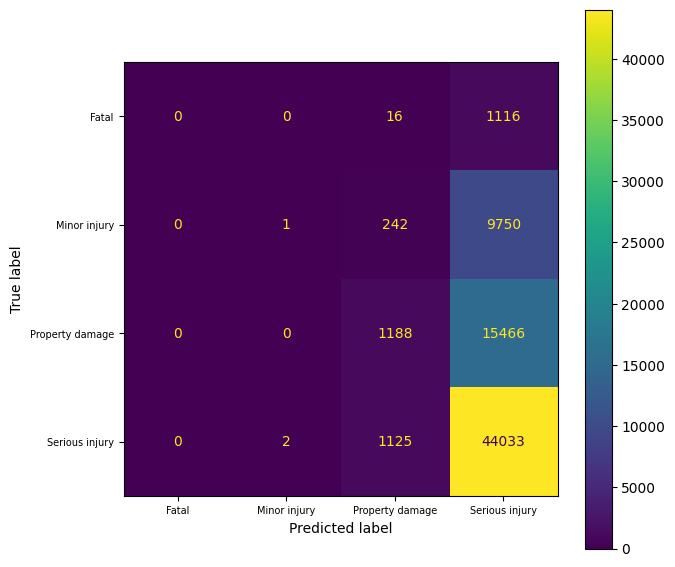

In [18]:
train_and_validate(model, train_loader, val_loader, optimizer, criterion, num_epochs=20)

evaluate_model(model, test_loader)